In [4]:
%load_ext autoreload
%autoreload 2
import os 
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import sys
sys.path.append('/home/amawi/projects/nn_ansatz/src')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import jax
from jax import pmap, vmap
from jax.tree_util import tree_flatten
from jax.experimental.optimizers import adam
import jax.numpy as jnp
from jax import lax

import numpy as np
from tqdm.notebook import trange
from functools import partial

import matplotlib.pyplot as plt
from matplotlib import cm

from nn_ansatz import *

In [8]:
cfg = config = setup(system='LiSolidBCC',
               n_pre_it=0,
               n_walkers=64,
               n_layers=2,
               n_sh=32,
               n_ph=8,
               opt='kfac',
               n_det=2,
               print_every=1,
               save_every=5000,
               n_it=1000)

logger = Logging(**cfg)

keys = rnd.PRNGKey(cfg['seed'])
if bool(os.environ.get('DISTRIBUTE')) is True:
    keys = rnd.split(keys, cfg['n_devices']).reshape(cfg['n_devices'], 2)

mol = SystemAnsatz(**cfg)

pwf = pmap(create_wf(mol), in_axes=(None, 0))
vwf = create_wf(mol)
jswf = jit(create_wf(mol, signed=True))
compute_ae_vectors = jit(partial(compute_ae_vectors_periodic_i, unit_cell_length=mol.unit_cell_length))

sampler = create_sampler(mol, vwf)

# params = initialise_params(mol, keys)
params = load_pk('params.pk')
# walkers = initialise_walkers(mol, vwf, sampler, params, keys, walkers=None)
# save_pk(walkers, 'walkers_no_infs.pk')
walkers = load_pk('walkers_no_infs.pk')

ke = jit(create_local_kinetic_energy(vwf))
pe = jit(create_potential_energy(mol))
keep_in_boundary = jit(keep_in_boundary)

version 		 010921
seed 		 369
n_devices 		 1
save_every 		 5000
print_every 		 1
exp_dir 		 /home/amawi/projects/nn_ansatz/src/scripts/debugging/periodicity/experiments/LiSolidBCC/010921/junk/kfac_1lr-4_1d-3_1nc-4_m64_s32_p8_l2_det2/run1
events_dir 		 /home/amawi/projects/nn_ansatz/src/scripts/debugging/periodicity/experiments/LiSolidBCC/010921/junk/kfac_1lr-4_1d-3_1nc-4_m64_s32_p8_l2_det2/run1/events
models_dir 		 /home/amawi/projects/nn_ansatz/src/scripts/debugging/periodicity/experiments/LiSolidBCC/010921/junk/kfac_1lr-4_1d-3_1nc-4_m64_s32_p8_l2_det2/run1/models
opt_state_dir 		 /home/amawi/projects/nn_ansatz/src/scripts/debugging/periodicity/experiments/LiSolidBCC/010921/junk/kfac_1lr-4_1d-3_1nc-4_m64_s32_p8_l2_det2/run1/models/opt_state
pre_path 		 /home/amawi/projects/nn_ansatz/src/scripts/debugging/periodicity/experiments/LiSolidBCC/pretrained/s32_p8_l2_det2_1lr-4_i0.pk
timing_dir 		 /home/amawi/projects/nn_ansatz/src/scripts/debugging/periodicity/experiments/LiSolidBCC/010921/j

In [7]:
@jit
def spline(walker, r_atoms, unit_cell_length):
    ae_vector = compute_ae_vectors(walker, r_atoms)
    ae_vector = jnp.where(ae_vector < -0.25 * unit_cell_length, -unit_cell_length**2/(8.*(unit_cell_length + 2.*ae_vector)), ae_vector)
    ae_vector = jnp.where(ae_vector > 0.25 * unit_cell_length, unit_cell_length**2/(8.*(unit_cell_length - 2.*ae_vector)), ae_vector)
    return ae_vector

spline = vmap(spline, in_axes=(0, None, None))

In [ ]:
# PLANE

# jwalker.shape (1, 6, 3)
# r_atoms.shape (2, 3)
walker = np.array(walkers[:, 0, ...])
rx0, ry0, rz0 = np.array(mol.r_atoms[1, :])
walker[0, 0, -1] = rz0
walker[0, 1, -1] = rz0
walker[0, 3, -1] = rz0

n_points = 100
X = np.linspace(rx0-mol.unit_cell_length, rx0+mol.unit_cell_length, n_points)
# idx = np.argmin(np.abs(X))
# X[idx] = 0.0

print(rz0)

data = []
for i, y1 in enumerate(X):
    for x1 in X:
        walker[0, 0] = jnp.array([[x1, y1, rz0]])
        jwalker = jnp.array(walker)

        # print(jwalker.shape, mol.r_atoms.shape)

        # ae_vectors = spline(jwalker, mol.r_atoms, mol.unit_cell_length)
        # mask = jnp.isinf(ae_vectors) 
        # max_ninf = mask.sum(-1).max()

        jwalker = keep_in_boundary(jwalker, mol.real_basis, mol.inv_real_basis)
        log_psi, sign = jswf(params, jwalker)
        amplitude = sign * jnp.exp(log_psi)
        probability = amplitude**2
        
        potential_energy = pe(jwalker, mol.r_atoms, mol.z_atoms)
        kinetic_energy = ke(params, jwalker)
        local_energy = potential_energy + kinetic_energy
        tmp = [y1, x1, amplitude.mean(), probability.mean(), local_energy.mean(), potential_energy.mean(), kinetic_energy.mean()]
        data.append(tmp)
    print('row %i' % (i+1), ' / %i' % n_points)

data = np.array(data)
data = pd.DataFrame(data, columns=['y', 'x', 'amps', 'probs', 'local_e', 'potential_e', 'kinetic_e'])
save_pk(data, 'electron_sweep1.pk')
print(data)

In [ ]:
XX, YY = np.meshgrid(X, X)

fig, axs = plt.subplots(3, 2, figsize=(14,14))
axs = [x for y in axs for x in y]

names = ['amps', 'local_e', 'potential_e', 'kinetic_e', 'max_ninf']

for ax, name in zip(axs, names):
    plot_data = data.pivot(index='x', columns='y', values=name).values
    plot_data = np.ma.masked_where(np.isnan(plot_data), plot_data)
    
    cmap = cm.get_cmap('cool', 3) if name is 'max_ninf' else cm.cool
    if name is not 'max_ninf':
        vmin, vmax = plot_data.min().min(), plot_data.max().max()  
    else:
        vmin, vmax = 0.5, 3.5
    
    plot_data = data.pivot(index='x', columns='y', values=name).values
    plot_data = np.ma.masked_where(np.isnan(plot_data), plot_data)
    p = ax.pcolor(XX, YY, plot_data, cmap=cmap, vmin=vmin, vmax=vmax, shading='auto')
    ax.scatter(mol.r_atoms[:, 0], mol.r_atoms[:, 1], color='r')
    ax.scatter(walker[0, 1, 0], walker[0, 1, 1], color='g')
    ax.scatter(walker[0, 3, 0], walker[0, 3, 1], color='g')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title(name)
    cb = fig.colorbar(p, ax=ax)
    # fig.suptitle('k = %.2f, min energy = %.6f / max energy  = %.6f' % (kappa, plot_data.min().min(), plot_data.max().max()))
fig.tight_layout()
plt.savefig('electron_sweep.png', facecolor='white', transparent=False)
plt.show()

In [12]:
# LINE

# PLANE

# jwalker.shape (1, 6, 3)
# r_atoms.shape (2, 3)
n_points = 100
X = np.linspace(rx0-mol.unit_cell_length, rx0+mol.unit_cell_length, n_points)

walker = np.array(walkers[:, 0, ...])
rx0, ry0, rz0 = np.array(mol.r_atoms[1, :])
walker[0, 0, -1] = rz0
walker[0, 1] = np.array([X[45] for _ in range(3)])
walker[0, 3] = np.array([X[60] for _ in range(3)])


# idx = np.argmin(np.abs(X))
# X[idx] = 0.0

print(rz0)

data = []
for i, x1 in enumerate(X):
    
    walker[0, 0] = jnp.array([[x1, x1, x1]])
    jwalker = jnp.array(walker)

    # print(jwalker.shape, mol.r_atoms.shape)

    jwalker = keep_in_boundary(jwalker, mol.real_basis, mol.inv_real_basis)
    jx, jy, jz = jwalker[0, 0]

    ae_vectors = spline(jwalker, mol.r_atoms, mol.unit_cell_length)
    mask = jnp.isinf(ae_vectors) 
    max_ninf = mask.sum(-1).max()

    log_psi, sign = jswf(params, jwalker)
    amplitude = sign * jnp.exp(log_psi)
    probability = amplitude**2
    
    potential_energy = pe(jwalker, mol.r_atoms, mol.z_atoms)
    kinetic_energy = ke(params, jwalker)
    local_energy = potential_energy + kinetic_energy
    tmp = [x1, x1, x1, jx, jy, jz, amplitude.mean(), probability.mean(), local_energy.mean(), potential_energy.mean(), kinetic_energy.mean(), max_ninf]
    data.append(tmp)
    print('row %i' % (i+1), ' / %i' % n_points)

data = np.array(data)
data = pd.DataFrame(data, columns=['y', 'x', 'z', 'jx', 'jy', 'jz', 'amps', 'probs', 'local_e', 'potential_e', 'kinetic_e', 'max_ninf'])
save_pk(data, 'line_electron_sweep.pk')
print(data)

3.315
row 1  / 100
row 2  / 100
row 3  / 100
row 4  / 100
row 5  / 100
row 6  / 100
row 7  / 100
row 8  / 100
row 9  / 100
row 10  / 100
row 11  / 100
row 12  / 100
row 13  / 100
row 14  / 100
row 15  / 100
row 16  / 100
row 17  / 100
row 18  / 100
row 19  / 100
row 20  / 100
row 21  / 100
row 22  / 100
row 23  / 100
row 24  / 100
row 25  / 100
row 26  / 100
row 27  / 100
row 28  / 100
row 29  / 100
row 30  / 100
row 31  / 100
row 32  / 100
row 33  / 100
row 34  / 100
row 35  / 100
row 36  / 100
row 37  / 100
row 38  / 100
row 39  / 100
row 40  / 100
row 41  / 100
row 42  / 100
row 43  / 100
row 44  / 100
row 45  / 100
row 46  / 100
row 47  / 100
row 48  / 100
row 49  / 100
row 50  / 100
row 51  / 100
row 52  / 100
row 53  / 100
row 54  / 100
row 55  / 100
row 56  / 100
row 57  / 100
row 58  / 100
row 59  / 100
row 60  / 100
row 61  / 100
row 62  / 100
row 63  / 100
row 64  / 100
row 65  / 100
row 66  / 100
row 67  / 100
row 68  / 100
row 69  / 100
row 70  / 100
row 71  / 100
row 72  /

(1, 6, 3)


ValueError: Axis limits cannot be NaN or Inf

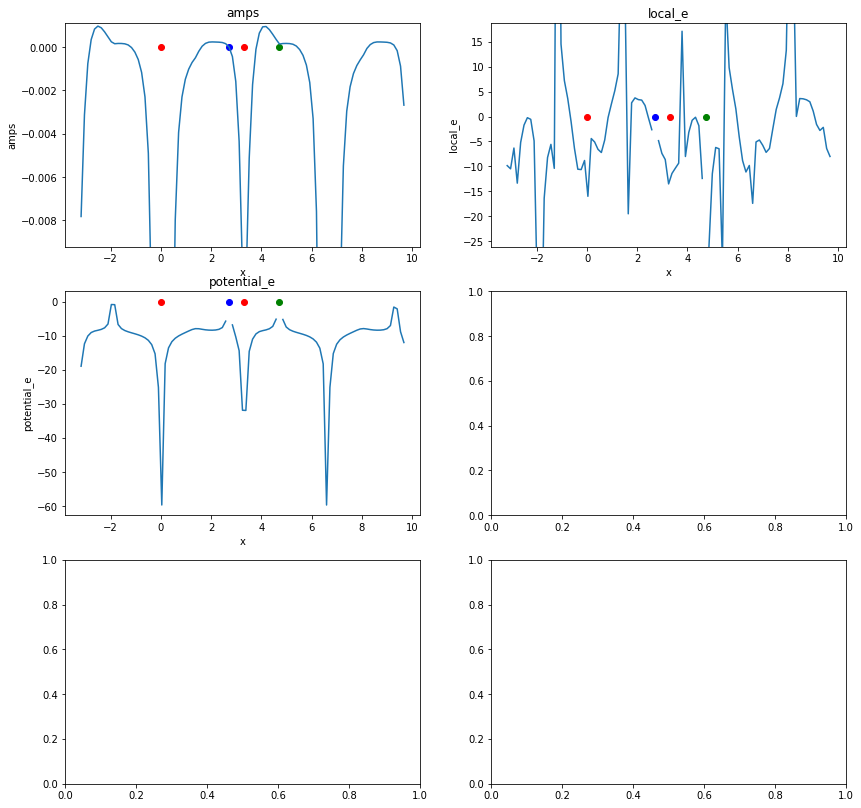

In [17]:
XX, YY = np.meshgrid(X, X)
print(walker.shape)

def set_lims(ax, data):
    are_negative = (data < 0.0).any()
    if are_negative:
        median_negative = np.median(data[data < 0.0])
        ymin = 4 * median_negative
    else:
        ymin = 0.
    median_positive = np.median(data[data > 0.0])
    ax.set_ylim(ymin, median_positive * 5.)
    
fig, axs = plt.subplots(3, 2, figsize=(14,14))
axs = [x for y in axs for x in y]

walker = keep_in_boundary(jnp.array(walker), mol.real_basis, mol.inv_real_basis)

names = ['amps', 'local_e', 'potential_e', 'kinetic_e', 'max_ninf', 'jx']

for ax, name in zip(axs, names):
    
    # cmap = cm.get_cmap('cool', 3) if name is 'max_ninf' else cm.cool
    # if name is not 'max_ninf':
    #     vmin, vmax = plot_data.min().min(), plot_data.max().max()  
    # else:
    #     vmin, vmax = 0.5, 3.5
    
    plot_data = data[name][1:-2]
    # plot_data = np.ma.masked_where(np.isnan(plot_data), plot_data)
    ax.plot(X[1:-2], plot_data)

    ax.scatter(mol.r_atoms[:, 0], [0., 0.], color='r')
    ax.scatter(walker[0, 1, 0], [0.0,], color='b')
    ax.scatter(walker[0, 3, 0], [0.0,], color='g')
    
    # ax.scatter(walker[0, 1, 0], walker[0, 1, 1], color='g')
    # ax.scatter(walker[0, 3, 0], walker[0, 3, 1], color='g')
    ax.set_xlabel('x')
    ax.set_ylabel(name)
    ax.set_title(name)
    set_lims(ax, plot_data)
    # cb = fig.colorbar(p, ax=ax)
    # fig.suptitle('k = %.2f, min energy = %.6f / max energy  = %.6f' % (kappa, plot_data.min().min(), plot_data.max().max()))
fig.tight_layout()
plt.savefig('line_electron_sweep.png', facecolor='white', transparent=False)
plt.show()

In [18]:
print(data[1:-2])

           y         x         z        jx        jy        jz      amps  \
1  -3.181061 -3.181061 -3.181061  3.448940  3.448940  3.448940 -0.007817   
2  -3.047121 -3.047121 -3.047121  3.582879  3.582879  3.582879 -0.003131   
3  -2.913182 -2.913182 -2.913182  3.716819  3.716819  3.716819 -0.000760   
4  -2.779242 -2.779242 -2.779242  3.850758  3.850758  3.850758  0.000347   
5  -2.645303 -2.645303 -2.645303  3.984697  3.984697  3.984697  0.000832   
..       ...       ...       ...       ...       ...       ...       ...   
93  9.141364  9.141364  9.141364  2.511364  2.511364  2.511364  0.000192   
94  9.275303  9.275303  9.275303  2.645302  2.645302  2.645302  0.000098   
95  9.409242  9.409242  9.409242  2.779242  2.779242  2.779242 -0.000164   
96  9.543182  9.543182  9.543182  2.913181  2.913181  2.913181 -0.000879   
97  9.677121  9.677121  9.677121  3.047121  3.047121  3.047121 -0.002679   

           probs    local_e  potential_e  kinetic_e  max_ninf  
1   6.110154e-05  -9.84